In [1]:
import time
import warnings
warnings.filterwarnings('ignore')

# For loading the dataframe
import pickle

# For loading data and data manipulation
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# For cleaning the text
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# For converting them into vectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# To find the similarity distance between movies
from sklearn.metrics.pairwise import cosine_similarity

# For model building libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Loading the datasets

In [2]:
df_predict = pickle.load(open("eda_data/predict.pkl", "rb"))
df_predict.head()

,Preferences,Category
0,I’m more of a tea person 🍵$$$I prefer herbal/d...,sweet
1,"I don’t drink coffee or tea 🤭$$$ Chocolates, C...",hard liquor
2,"I don’t drink coffee or tea 🤭$$$ Chocolates, C...",accessory
3,"I don’t drink coffee or tea 🤭$$$ Chocolates, C...",liquoraccessory
4,"I don’t drink coffee or tea 🤭$$$ Chocolates, C...",sweet


# Clean the preference

In [3]:
# Creating object of tokenizer and lemmatizer
tokenizer = RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()

In [4]:
# Function to clean the Preference column
def clean_pref(row):
    # convert into lower character
    row = row.lower()
    # split string into words
    words = tokenizer.tokenize(row)
    # remove stop words and apply lemmatization
    words = [lemmatizer.lemmatize(word.strip()) for word in words if word not in stopwords.words('english')]
    # convert word into string again and return
    return ' '.join(words)

In [5]:
%%time
# Applying clean preference function to transform the text
df_predict['Preference_Clean'] = df_predict['Preferences'].apply(clean_pref)

CPU times: user 7.87 s, sys: 1.33 s, total: 9.2 s
Wall time: 9.2 s


In [6]:
df_predict.head()

,Preferences,Category,Preference_Clean
0,I’m more of a tea person 🍵$$$I prefer herbal/d...,sweet,tea person prefer herbal de caffeinated tea ch...
1,"I don’t drink coffee or tea 🤭$$$ Chocolates, C...",hard liquor,drink coffee tea chocolate candy baked treat s...
2,"I don’t drink coffee or tea 🤭$$$ Chocolates, C...",accessory,drink coffee tea chocolate candy baked treat s...
3,"I don’t drink coffee or tea 🤭$$$ Chocolates, C...",liquoraccessory,drink coffee tea chocolate candy baked treat s...
4,"I don’t drink coffee or tea 🤭$$$ Chocolates, C...",sweet,drink coffee tea chocolate candy baked treat s...


# Split the data into train and test

In [7]:
X = df_predict['Preference_Clean']
y = df_predict['Category']

X.shape, y.shape

((3127,), (3127,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2501,), (626,), (2501,), (626,))

# Converting feature into vectors

In [9]:
tfidf_predict = TfidfVectorizer(max_features=3000, stop_words='english')

In [10]:
X_train_vec = tfidf_predict.fit_transform(X_train).toarray()
X_test_vec = tfidf_predict.transform(X_test).toarray()

In [11]:
X_train_vec.shape

(2501, 564)

# Creating a model

<AxesSubplot:>

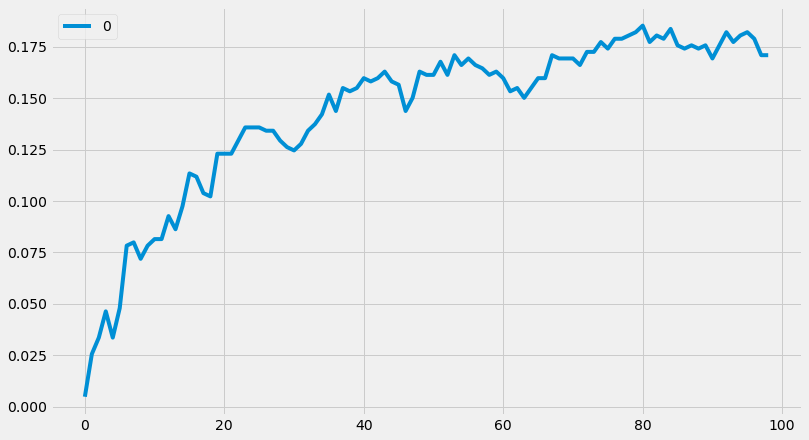

In [12]:
# Checking for the best value of n_neighbours in KNN
accuracy_knn = []
for i in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_vec, y_train)
    y_pred = knn.predict(X_test_vec)
    accuracy_knn.append(accuracy_score(y_test, y_pred))
    
pd.DataFrame(accuracy_knn).plot(figsize=(12,7))

### Increase the model performance:
* Initially there were 39 categories, and I am getting the best accuracy of **18 percent**
* After that I found out there were some categories which were redundant with a difference of upper and lower character, so after converting all categories to lower character, and I am getting the best accuracy of around **20 percent**
* Then to improve further I remove the categories that has less than 50 records, and I am getting the best accuracy of **23 percent**

In [13]:
svc = SVC(kernel='sigmoid', gamma=1.0, probability=True)
knc = KNeighborsClassifier(n_neighbors=80)
bnb = BernoulliNB()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)

In [14]:
%%time
model_perf = []
classifiers = [svc, knc, bnb, mnb, dtc, lrc, rfc, abc, bc, etc, gbdt]
for classifier in classifiers:
    classifier.fit(X_train_vec, y_train)
    y_pred = classifier.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    model_perf.append({'Model': classifier, 'Accuracy': accuracy})

CPU times: user 29.4 s, sys: 1.63 s, total: 31.1 s
Wall time: 27.5 s


### Model performance

In [15]:
pd.DataFrame(model_perf)

,Model,Accuracy
0,"SVC(gamma=1.0, kernel='sigmoid', probability=T...",0.230032
1,KNeighborsClassifier(n_neighbors=80),0.182109
2,BernoulliNB(),0.194888
3,MultinomialNB(),0.166134
4,DecisionTreeClassifier(max_depth=5),0.170927
5,"LogisticRegression(penalty='l1', solver='libli...",0.230032
6,"(DecisionTreeClassifier(max_features='auto', r...",0.015974
7,"(DecisionTreeClassifier(max_depth=1, random_st...",0.188498
8,(DecisionTreeClassifier(random_state=114693939...,0.012780
9,"(ExtraTreeClassifier(random_state=1872583848),...",0.020767


# Creating recommendation model

In [16]:
df_recommend = pickle.load(open("eda_data/recommendation.pkl", 'rb'))
df_recommend.head()

,ProductId,ProductName,ProductTag,Rating,Cost,Price,Tag
0,245,Guatemalan Signature Roast Ground Coffee,"coffee, ground",4.4427,13.78,25.99,guatemalan signature roast ground coffee coffe...
1,278,Los Gigantes Colombia (Coffee Beans),"coffee, artisanal",4.3185,10.75,20.00,los gigantes colombia coffee bean coffee artis...
2,351,Rowkin Bit Charge Stereo (Silver),music,4.0000,64.00,102.99,rowkin bit charge stereo silver music
3,424,Chocolate Fruit and Nut Dragee Sampler,sweet,4.4643,21.00,35.00,chocolate fruit nut dragee sampler sweet
4,700,Pro Lens Kit for Phone Camera,photography,4.3588,24.50,42.99,pro lens kit phone camera photography


### Converting tags column into vectors

In [17]:
tfidf_recommend = TfidfVectorizer(max_features=5000, stop_words='english')

In [18]:
recommend_vec = tfidf_recommend.fit_transform(df_recommend['Tag']).toarray()
recommend_vec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
recommend_vec.shape

(341, 781)

### Calculate the cosine distance between the vectors, and the values of matrix represent the percentage of similarity between tags

In [20]:
similarity = cosine_similarity(recommend_vec)
similarity

array([[1.        , 0.25549427, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.25549427, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.87744968],
       [0.        , 0.        , 0.        , ..., 0.        , 0.87744968,
        1.        ]])

In [21]:
similarity.shape

(341, 341)

### Recommender function that will give the recommended movies closest to the given one

In [22]:
def recommender(product):
    product_index = df_recommend[df_recommend['ProductName'] == product].index[0]
    similarity_percentage = similarity[product_index]
    recommended_product = sorted(list(enumerate(similarity_percentage)), reverse=True, key=lambda x:x[1])[1:6]
    
    products = []
    for index in recommended_product:
        products.append(df_recommend.iloc[index[0]]['ProductName'])
        
    return products

In [23]:
recommender("Pecan Shortbread cookies")

['Vanilla Bean Shortbread Cookies',
 'The Luxe Collection Cocoa Shortbread',
 'Chocolate Cacao Nib Shortbread',
 'Original Speculoos Cookies- 4.8oz',
 'The Luxe Collection Almond Butter Cookies']

# Pipeline that recommends products on the basis of preference

In [24]:
def pipeline(pref):
    # creating a dataframe
    df = pd.DataFrame({"Preference": [pref]})
    
    # cleaning the preference
    df['Preference_Clean'] = df['Preference'].apply(clean_pref)
    
    # transform the preference into vectors
    df_vec = tfidf_predict.transform(df['Preference_Clean']).toarray()
    
    # predict the category
    pred = svc.predict(df_vec)[0]
    print("Predicted Tag:", pred)
    
    # predict probability
    pred_prob = svc.predict_proba(df_vec)[0]
    
    # dictionary of category with its probability
    category_prob = {}
    for i in range(len(pred_prob)):
        category_prob[svc.classes_[i]] = pred_prob[i]
    
    # sort the dictionary to get the max two
    category_prob_sort = dict(sorted(category_prob.items(), key=lambda item: item[1], reverse=True))
    pred_two = list(category_prob_sort.keys())[:2]
    print("\nProduct tag sorted:", category_prob_sort)
    
    # fecthing all the products which has category as product
    df_product = df_recommend[df_recommend['ProductTag'].apply(lambda product_tag: pred in product_tag.lower())]
    df_product = df_product[['ProductId', 'ProductName', 'Cost', 'Price']]
    
    product_name = df_product.iloc[0]['ProductName']
    print("\nProduct Name:", product_name)
    
    # recommend product similar to product name
    print("\nRecommended products:")
    print("--------------------------")
    recommends = recommender(product_name)
    for recommend in recommends:
        print(recommend)

# Check with test data

In [25]:
df_test_sample = pd.read_csv("data/test_input.csv")
df_test_sample.head()

,Unnamed: 0,OrderID,OrderPrice,Preferences
0,1001,171888537,40,I'm a coffee person ☕️$$$I love to make pour o...
1,1002,171888536,40,I'm a coffee person ☕️$$$I love to make pour o...
2,1003,171888535,40,"I don’t drink coffee or tea 🤭$$$ Chocolates, C..."
3,1004,171888533,30,I'm a coffee person ☕️$$$I love to make pour o...
4,1005,171888532,50,I’m more of a tea person 🍵$$$Any specialty tea...


In [26]:
df_test_sample = df_test_sample[['OrderPrice', 'Preferences']]
df_test_sample.head()

,OrderPrice,Preferences
0,40,I'm a coffee person ☕️$$$I love to make pour o...
1,40,I'm a coffee person ☕️$$$I love to make pour o...
2,40,"I don’t drink coffee or tea 🤭$$$ Chocolates, C..."
3,30,I'm a coffee person ☕️$$$I love to make pour o...
4,50,I’m more of a tea person 🍵$$$Any specialty tea...


In [27]:
test_str = df_test_sample['Preferences'][8]
test_str

'I’m more of a tea person 🍵$$$Any specialty tea is good for me 🍵$$$ Savories and non-sweet snacks 🥓 🥕🥨 $$$  I do NOT have any allergies or dietary restrictions 👍 $$$ $$$Send 👍$$$I like everything 👍$$$ 📸 I enjoy capturing pictures &amp; videos $$$  📱🏡 Smart home gadgets are so cool. I love them. $$$ $$$Send 👍$$$Oh yeah! 🤘$$$L'

In [28]:
pipeline(test_str)

Predicted Tag: tea

Product tag sorted: {'tea': 0.4345222547339818, 'savoury': 0.14465244832048949, 'accessory': 0.08541780127888425, 'liquoraccessory': 0.08440344815587061, 'wine': 0.06099323957232824, 'photography': 0.05890583355054368, 'smart product': 0.04290792189142331, 'hard liquor': 0.02280073620171658, 'healthy treat': 0.021727592847630012, 'gadget': 0.016071469341727467, 'sweet': 0.011183916546929927, 'health and fitness': 0.010392146083540306, 'artisanal': 0.002938243909085043, 'coffee': 0.001774815538351165, 'ground': 0.0013081320274981245}

Product Name: Everyday English Breakfast Tea Pyramid Bags (TIN)

Recommended products:
--------------------------
Relax Tea Pyramid Bags (TIN)
Sleep Tea Pyramid Bags (TIN)
Immunity Tea Pyramid Bags (TIN)
English Breakfast - 20 Teabags in Signature Tea Tin
Mini Signature Box (Five Pyramid Bags)
